In an ITS study, a time series of a particular outcome of interest is used to establish an underlying trend, which is ‘interrupted’ by an intervention at a known point in time.

The hypothetical scenario under which the intervention had not taken place and the trend continues unchanged (that is: the ‘expected’ trend, in the absence of the intervention, given the pre-existing trend) is referred to as the ‘counterfactual’.

In [ ]:
data <- read.csv('https://raw.githubusercontent.com/RInterested/DATASETS/gh-pages/sicily.csv')
names(data)[names(data) == 'aces'] <- 'infarcts'
head(data)

,year,month,infarcts,time,smokban,pop,stdpop
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,2002,1,728,1,0,364277.4,379875.3
2,2002,2,659,2,0,364277.4,376495.5
3,2002,3,791,3,0,364277.4,377040.8
4,2002,4,734,4,0,364277.4,377116.4
5,2002,5,757,5,0,364277.4,377383.4
6,2002,6,726,6,0,364277.4,374113.1


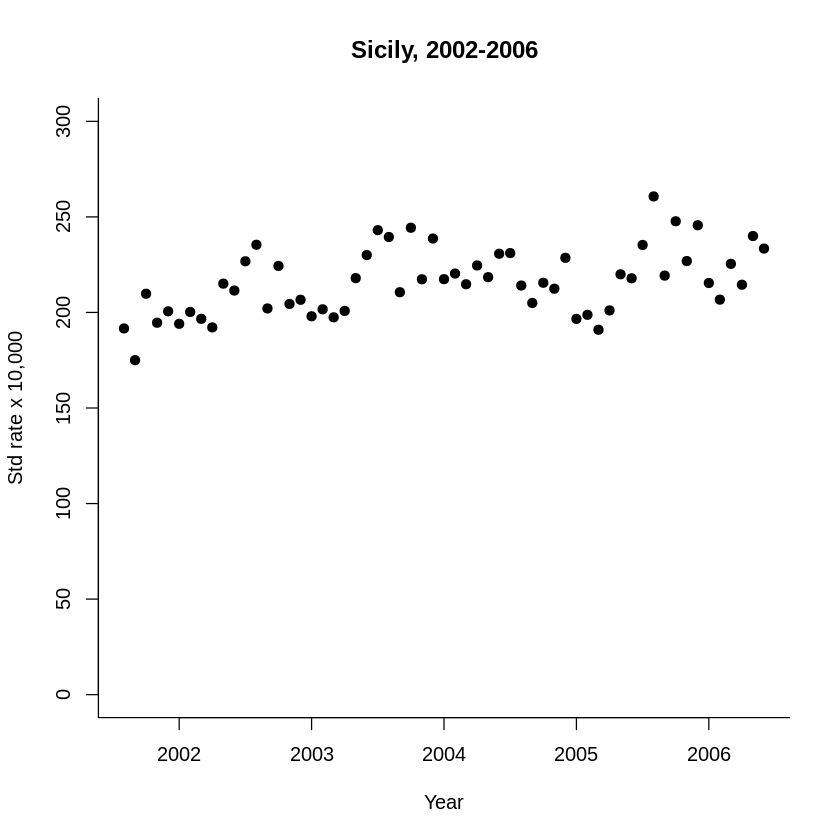

In [ ]:
data$infarct.rate <- with(data, infarcts/stdpop*10^5)

plot(data$infarct.rate, ylim=c(00,300), xlab="Year", ylab="Std rate x 10,000",
      pch=19, bty="l", xaxt="n")

axis(1, at=0:4*12 + 6, labels=2002:2006)
title("Sicily, 2002-2006")

Is the data stationary, i.e. there is no seasonality, there is no trend, the variance remains constant?

From [here](https://stats.stackexchange.com/a/74426/67822), [here](https://a-little-book-of-r-for-time-series.readthedocs.io/en/latest/src/timeseries.html) and [here](https://stats.stackexchange.com/a/57761/67822).

In [ ]:
# Seasonality, trend and variance:
install.packages('forecast')
library(forecast)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



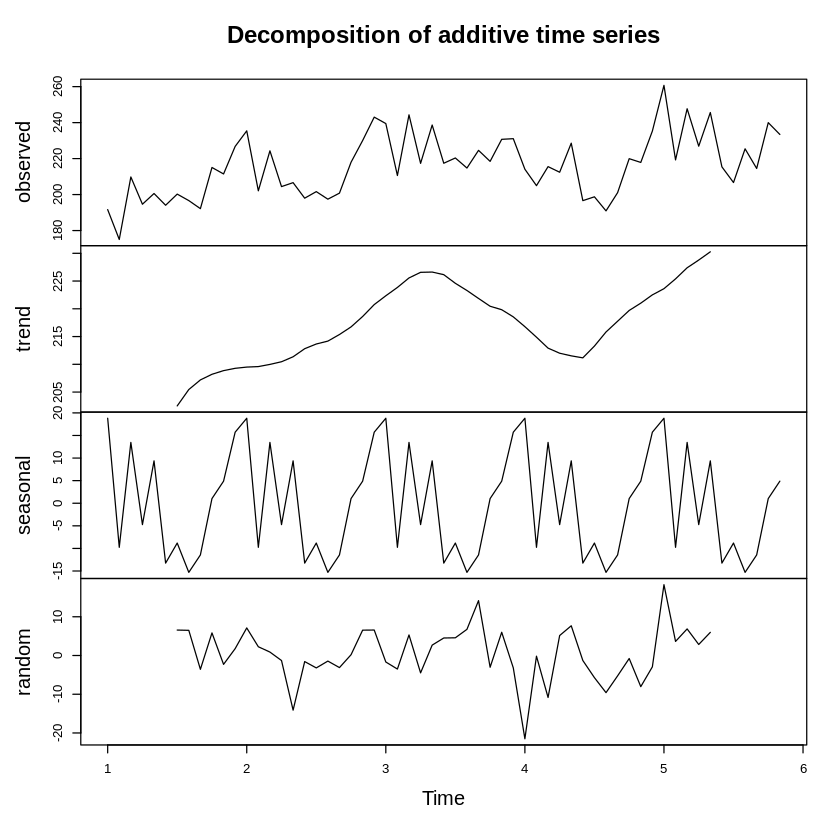

In [ ]:
components <- decompose(ts(data$infarct.rate, frequency=12))
plot(components)

In [ ]:
# Is there seasonality in the dataset?

x <- ts(data$infarct.rate, frequency=12) # 12 measurements per year
fit <- tbats(x)
!is.null(fit$seasonal)

[1] TRUE

In [ ]:
# Is the variance constant?

first.half <- data$infarct.rate[1: floor(0.5 * length(data$infarct.rate))]
second.half <- data$infarct.rate[ceiling(0.5 * length(data$infarct.rate)):length(data$infarct.rate)]

In [ ]:
# The variance increases over time:

(ratio <- var(first.half) / var(second.half) )

[1] 1.300939

In [ ]:
# Is it statistically significant?

var.test(first.half,second.half)


	F test to compare two variances

data:  first.half and second.half
F = 1.3009, num df = 28, denom df = 29, p-value = 0.4853
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.6164912 2.7589393
sample estimates:
ratio of variances 
          1.300939 


In [ ]:
# Is there a trend?

summary(lm(infarct.rate ~ time, data))


Call:
lm(formula = infarct.rate ~ time, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-31.866  -9.860  -3.236   9.517  35.518 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 201.7192     4.0603  49.681  < 2e-16 ***
time          0.4792     0.1177   4.071 0.000146 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.4 on 57 degrees of freedom
Multiple R-squared:  0.2253,	Adjusted R-squared:  0.2117 
F-statistic: 16.57 on 1 and 57 DF,  p-value: 0.0001459


In [ ]:
# The independent variable is counts, so we try fitting a Poisson regression model:

install.packages('Epi')
library(Epi)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
model1 <- glm(infarcts ~ offset(log(stdpop)) + smokban + time, family=poisson, data)
summary(model1)
round(ci.lin(model1,Exp=T),3) # Confidence intervals


Call:
glm(formula = infarcts ~ offset(log(stdpop)) + smokban + time, 
    family = poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4336  -1.4432  -0.4431   1.2735   5.0701  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.2431509  0.0111894 -557.955  < 2e-16 ***
smokban     -0.1116284  0.0172248   -6.481 9.13e-11 ***
time         0.0049450  0.0004992    9.905  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 308.52  on 58  degrees of freedom
Residual deviance: 197.31  on 56  degrees of freedom
AIC: 708.03

Number of Fisher Scoring iterations: 3


,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
(Intercept),-6.243,0.011,-557.955,0,0.002,0.002,0.002
smokban,-0.112,0.017,-6.481,0,0.894,0.865,0.925
time,0.005,0.000,9.905,0,1.005,1.004,1.006


,stdpop,smokban,time,month
,<dbl>,<dbl>,<dbl>,<dbl>
1,383464.4,0,0.1,0.1
2,383464.4,0,0.2,0.2
3,383464.4,0,0.3,0.3
4,383464.4,0,0.4,0.4
5,383464.4,0,0.5,0.5
6,383464.4,0,0.6,0.6


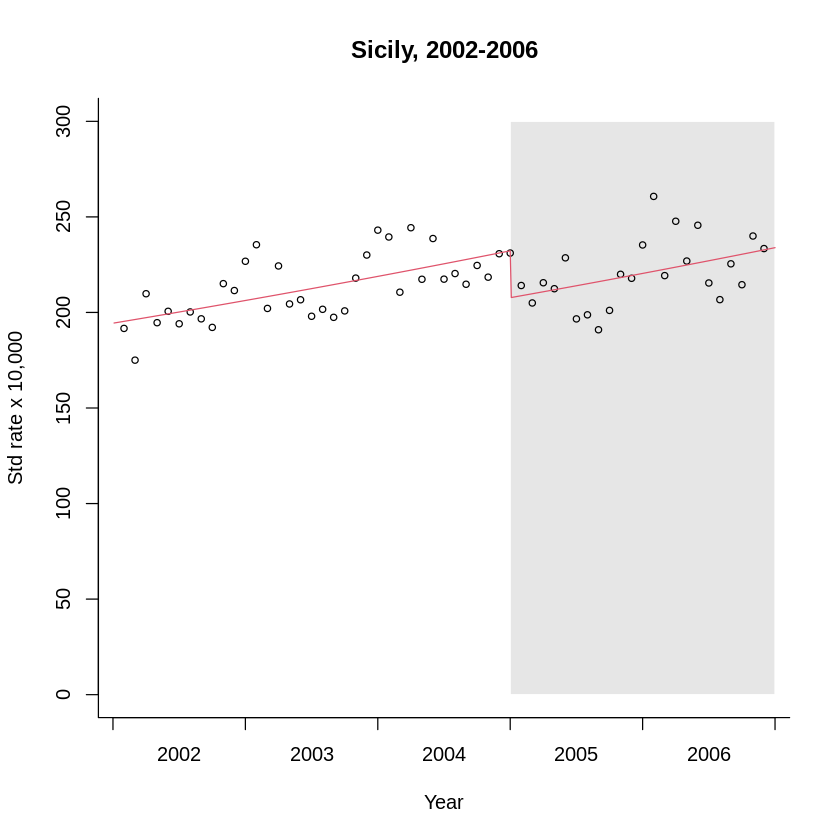

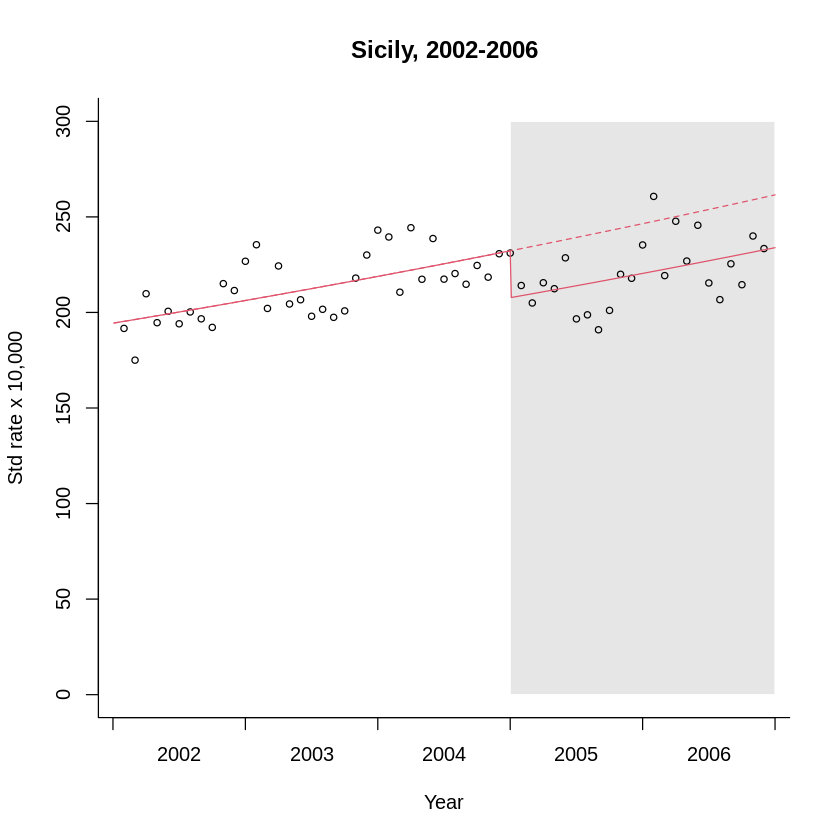

In [ ]:
# Predictions:

datanew <- data.frame(stdpop = mean(data$stdpop),
                      smokban = rep(c(0, 1), c(360, 240)),
                      time = 1:600/10,
                      month = rep(1:120/10, 5))

head(datanew)

pred1 <- predict(model1, type="response", datanew) / mean(data$stdpop) * 10^5

plot(data$infarct.rate, type="n", ylim=c(0,300), xlab="Year", ylab="Std rate x 10,000", bty="l", xaxt="n")
rect(36, 0, 60, 300, col=grey(0.9), border=F)
points(data$infarct.rate,cex=0.7)
axis(1, at=0:5*12, labels=F)
axis(1, at=0:4*12+6, tick=F, labels=2002:2006)
lines((1:600/10), pred1, col=2)
title("Sicily, 2002-2006")



# To plot the counterfactual scenario we create a data frame as if smokban (the intervention) had never been implemented.

datanew <- data.frame(stdpop=mean(data$stdpop),smokban=0,time=1:600/10,
  month=rep(1:120/10,5))

pred1b <- predict(model1, datanew, type="response") / mean(data$stdpop) * 10^5

plot(data$infarct.rate, type="n", ylim=c(0,300), xlab="Year", ylab="Std rate x 10,000", bty="l", xaxt="n")
rect(36, 0, 60, 300, col=grey(0.9), border=F)
points(data$infarct.rate,cex=0.7)
axis(1, at=0:5*12, labels=F)
axis(1, at=0:4*12+6, tick=F, labels=2002:2006)
lines((1:600/10), pred1, col=2)
lines(datanew$time, pred1b, col=2, lty=2)
title("Sicily, 2002-2006")

In the model above we have not allowed for overdispersion - in order to do this we can use a quasipoisson model, which allows the variance to be proportional rather than equal to the mean.

In [ ]:
# Quasi-Poisson model:

model2 <- glm(infarcts ~ offset(log(stdpop)) + smokban + time,
              family=quasipoisson, data)
summary(model2)


Call:
glm(formula = infarcts ~ offset(log(stdpop)) + smokban + time, 
    family = quasipoisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4336  -1.4432  -0.4431   1.2735   5.0701  

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -6.2431509  0.0211096 -295.749  < 2e-16 ***
smokban     -0.1116284  0.0324959   -3.435  0.00112 ** 
time         0.0049450  0.0009418    5.250 2.43e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 3.559195)

    Null deviance: 308.52  on 58  degrees of freedom
Residual deviance: 197.31  on 56  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 3


A second assumption of standard regression models is that observations are independent. This assumption is often violated in time series data because consecutive observations tend to be more similar to one another than those that are further apart, a phenomenon known as autocorrelation. Fortunately, in many epidemiological data, autocorrelation is largely explained by other variables, in particular seasonality (discussed above); therefore, after controlling for these factors, residual autocorrelation is rarely a problem. Nevertheless, **autocorrelation should always be assessed by examining the plot of residuals** and the partial autocorrelation function and, where data are normally distributed, conducting tests such as the Breusch-Godfrey test. Where residual autocorrelation remains, this should be adjusted for using methods such as Prais regression or autoregressive integrated moving average (ARIMA), described in more detail elsewhere. There is very little evidence of autocorrelation in the worked example and even less after adjustment for seasonality:

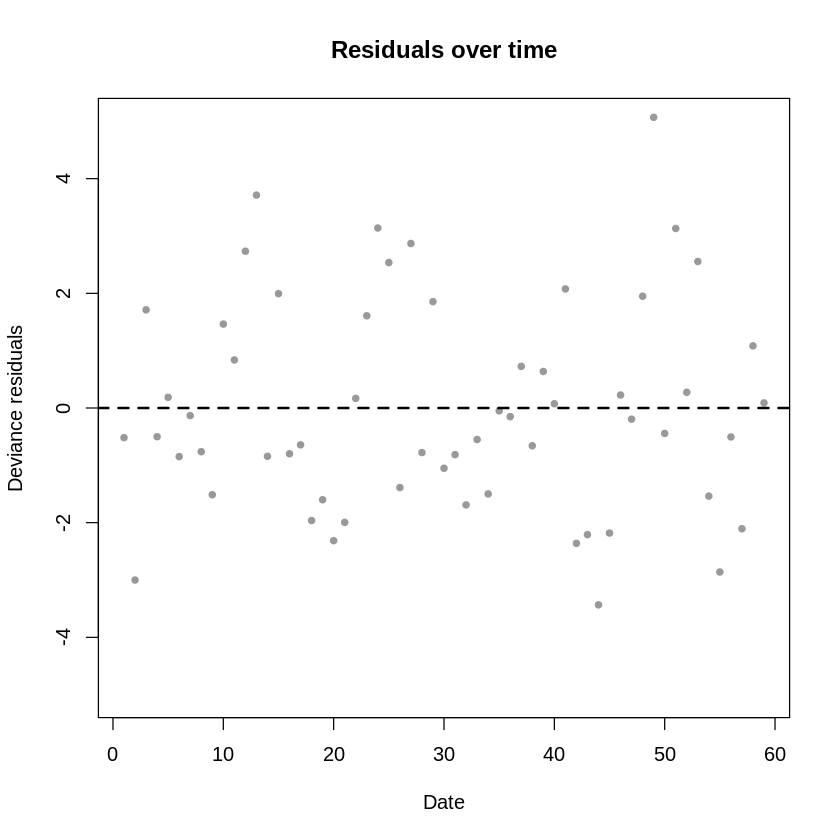

In [ ]:
# Checking residuals:

res2 <- residuals(model2,type="deviance")

plot(data$time, res2, ylim=c(-5,5), pch=19, cex=0.7, col=grey(0.6), main="Residuals over time", ylab="Deviance residuals", xlab="Date")

abline(h=0, lty=2, lwd=2)

In [ ]:
# Checking autocorrelation and partial autocorrelation:

install.packages('cowplot')
library(cowplot)

install.packages('fpp2')
library(fpp2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching packages ────────────────────────────────────────────── fpp2 2.4 ──

✔ ggplot2   3.3.6     ✔ expsmooth 2.3  
✔ fma       2.4       





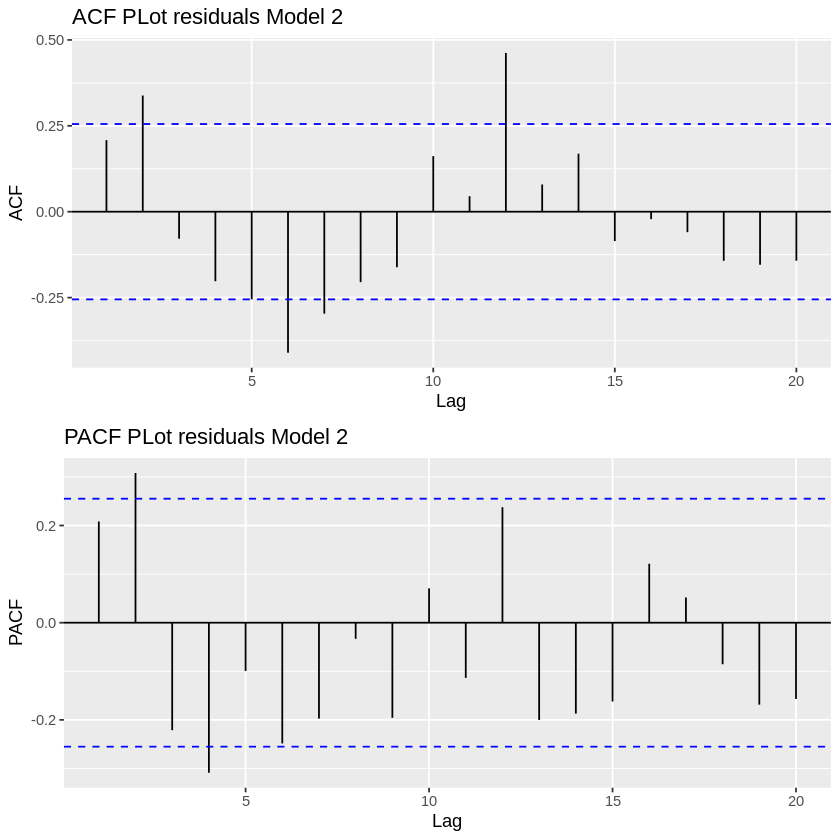

In [ ]:
# ACF plot
r1 <- ggAcf(res2, lag.max = 20) + labs(title = "ACF PLot residuals Model 2")
# PACF plot
r2 <- ggPacf(res2, lag.max = 20) + labs(title = "PACF PLot residuals Model 2")
# Plot both
plot_grid(r1, r2, ncol = 1)

There are various ways of adjusting for seasonality - here we use harmonic terms specifying the number of sin and cosine pairs to include (in this case 2) and the length of the period (12 months):

In [ ]:
# Adjusting for seasonality with Fourier harmonics:

install.packages('tsModel')
library(tsModel)

model3 <- glm(infarcts ~ offset(log(stdpop)) + smokban + time + harmonic(month,2,12),
              family=quasipoisson, data)
summary(model3)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Time Series Modeling for Air Pollution and Health (0.6-1)




Call:
glm(formula = infarcts ~ offset(log(stdpop)) + smokban + time + 
    harmonic(month, 2, 12), family = quasipoisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5292  -1.2634  -0.0972   1.2571   3.6882  

Coefficients:
                          Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             -6.2523723  0.0175689 -355.877  < 2e-16 ***
smokban                 -0.1220868  0.0270311   -4.517 3.64e-05 ***
time                     0.0053892  0.0007955    6.774 1.13e-08 ***
harmonic(month, 2, 12)1  0.0370967  0.0100241    3.701 0.000520 ***
harmonic(month, 2, 12)2 -0.0182122  0.0096435   -1.889 0.064537 .  
harmonic(month, 2, 12)3  0.0381608  0.0096848    3.940 0.000244 ***
harmonic(month, 2, 12)4  0.0147634  0.0097221    1.519 0.134935    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 2.262186)

    Null deviance: 308.52  on 58  degrees of freedom
R

In [ ]:
round(ci.lin(model3,Exp=T),3)

,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
(Intercept),-6.252,0.018,-355.877,0.000,0.002,0.002,0.002
smokban,-0.122,0.027,-4.517,0.000,0.885,0.839,0.933
time,0.005,0.001,6.774,0.000,1.005,1.004,1.007
"harmonic(month, 2, 12)1",0.037,0.010,3.701,0.000,1.038,1.018,1.058
"harmonic(month, 2, 12)2",-0.018,0.010,-1.889,0.059,0.982,0.964,1.001
"harmonic(month, 2, 12)3",0.038,0.010,3.940,0.000,1.039,1.019,1.059
"harmonic(month, 2, 12)4",0.015,0.010,1.519,0.129,1.015,0.996,1.034


In [ ]:
ci.lin(model3,Exp=T)["smokban",5:7]

exp(Est.)      2.5%     97.5% 
0.8850715 0.8394010 0.9332270

After adjustment for seasonality through a Fourier term, with results suggesting that the association is largely unaffected: `(RR: 0.885; 95% CI 0.839-0.933; P < 0.001).`

Taking into account seasonality of the infarct rate, the infarct rate was being multiplied by about 1.07 each year, a long-term temporal trend.

In [ ]:
exp(coef(model3)["time"]*12)

time 
1.066808

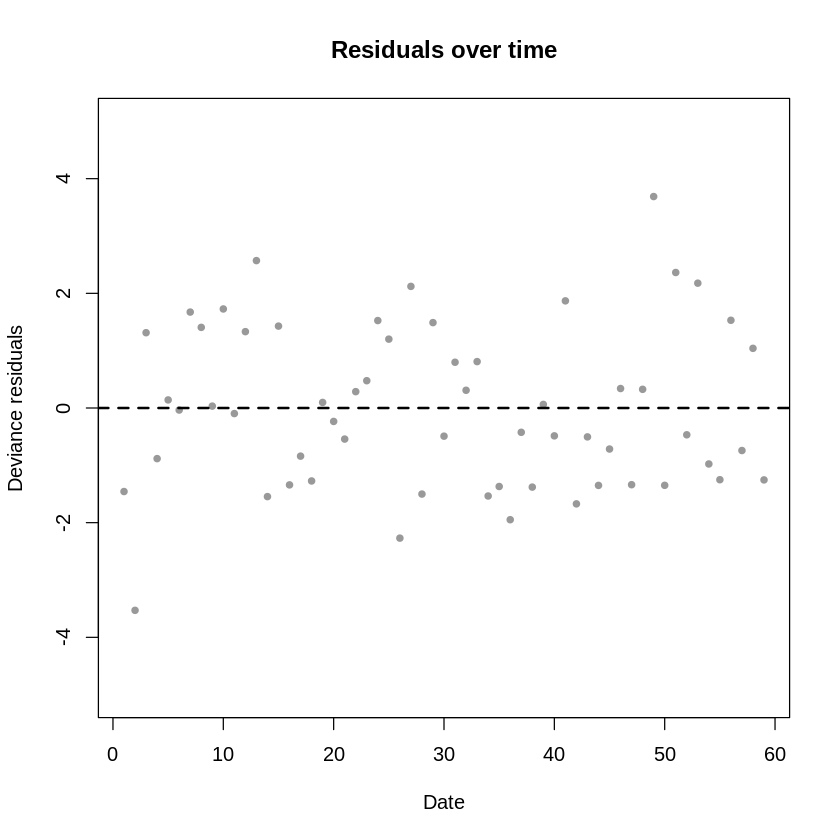

In [ ]:
# After adjusting for seasonality:

# Checking residuals:

res3 <- residuals(model3,type="deviance")

plot(data$time, res3, ylim=c(-5,5), pch=19, cex=0.7,
   col=grey(0.6), main="Residuals over time", ylab="Deviance residuals", xlab="Date")

abline(h=0, lty=2, lwd=2)

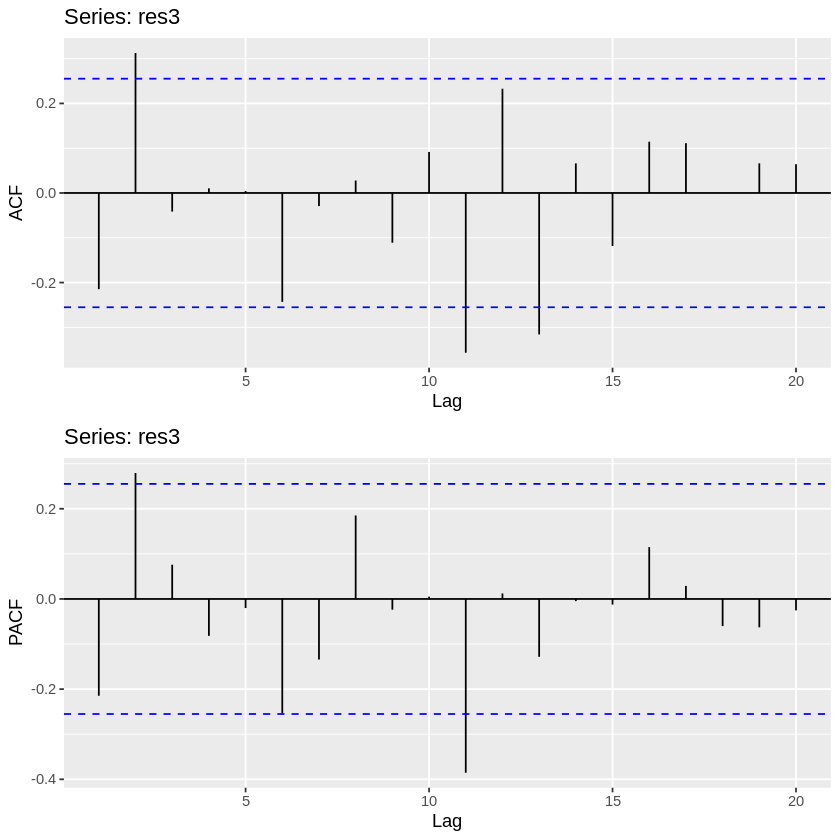

In [ ]:
# ACF plot
o1 <- ggAcf(res3, lag.max = 20)
# PACF plot
o2 <- ggPacf(res3, lag.max = 20)
# Plot both
plot_grid(o1, o2, ncol = 1)

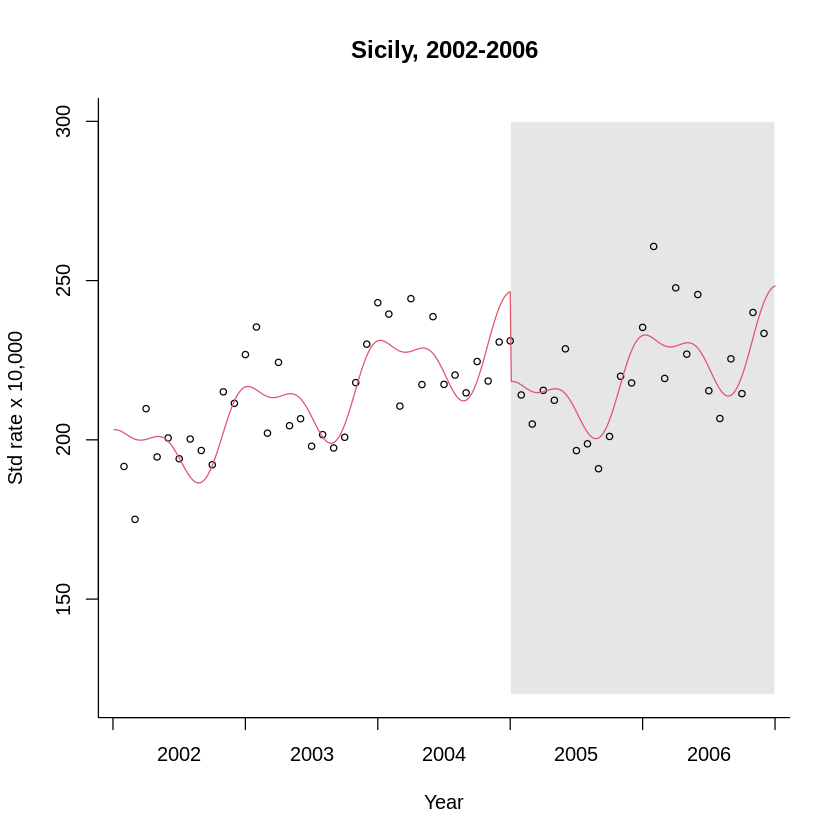

In [ ]:
# Predict and plot of the seasonally adjusted model


datanew <- data.frame(stdpop = mean(data$stdpop),
                      smokban = rep(c(0, 1), c(360, 240)),
                      time = 1:600/10,
                      month = rep(1:120/10, 5))

pred3 <- predict(model3, type="response", datanew) / mean(data$stdpop) * 10^5

plot(data$infarct.rate, type="n", ylim=c(120,300), xlab="Year", ylab="Std rate x 10,000", bty="l", xaxt="n")
rect(36, 120, 60, 300, col=grey(0.9), border=F)
points(data$infarct.rate, cex=0.7)
axis(1, at=0:5*12, labels=F)
axis(1, at=0:4*12+6, tick=F, labels=2002:2006)
lines(1:600/10, pred3, col=2)
title("Sicily, 2002-2006")